## Low-rank Matrix Completion via Riemannian Optimization -- Numerical Experiments

For this problem we implement the three approaches for low-rank matrix completion described in problems 1-3 of Homework 3.

Please fill in the gaps in the code blocks below. 

</span>$\color{red}{\text{Please write your own code.}}$



### Setting up

You may find it helpful to utilize the [Manopt toolbox](https://pymanopt.org/).
* Familiarize yourself with the available manifold classes in the API reference.
* Familiarize yourself with the avialable optimizers in the API reference.

In [1]:
# Install required packages.
%pip install pymanopt
%pip install autograd
%pip install manifolds

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### (a) Implement manifold descriptors and related geometric tools.


In [2]:
import numpy as np
import autograd.numpy as anp
import pymanopt
from pymanopt.manifolds import Product, Stiefel, Euclidean, FixedRankEmbedded
from pymanopt.optimizers import SteepestDescent

anp.random.seed(7)
np.random.seed(0)

# Parameters
m = 200 # matrix has size m x n
n = 500 
r = 5 # matrix has rank r
         

In [3]:
# Manifold 1: Product of linear spaces

manifold1 = Product([
    Euclidean(m, r),
    Euclidean(n, r)
])

In [4]:
# Manifold 2: Product of Stiefel manifold and linear space

manifold2 = Product([
    Stiefel(m, r),
    Euclidean(n, r)
])

In [5]:
# Manifold 3: Manifold of fixed-rank matrices

manifold3 = FixedRankEmbedded(m, n, r)

### (b) Generate test data

See homework set for specific instructions.

In [6]:
##############
#  Your code #
##############

def generate_data(m, n, r, rate):
    U_true = np.random.randn(m, r)
    V_true = np.random.randn(n, r)
    M_true = U_true @ V_true.T

    sampling_rate = rate
    B = (np.random.rand(m, n) < sampling_rate).astype(float)
    # M_tilde = M_true * B

    noise_std = 0.1
    noise = noise_std * np.random.randn(m, n)
    M_tilde = (M_true + noise) * B
    return M_tilde, B

M_tilde, B = generate_data(m, n, r, 0.3)

### (c) Use Riemannian Gradient Descent (with line search) to compute low-rank matrix completion with the three different approaches.

You may use the Manopt implementation of RGD or implement the algorithm yourself as an exercise.

In [7]:
# Approach 1

@pymanopt.function.autograd(manifold1)
def cost1(L, R):
    G = (anp.dot(L, R.T) - M_tilde) * B
    return 0.5 * anp.linalg.norm(G, 'fro')**2

problem1 = pymanopt.Problem(manifold=manifold1, cost=cost1)
solver1 = SteepestDescent(max_iterations=25000, min_gradient_norm=1e-4, verbosity=1)
result1 = solver1.run(problem1)

L_opt, R_opt = result1.point
X_opt1 = L_opt @ R_opt.T
E1 = (X_opt1 - M_tilde) * B
print("Approach 1 final loss:", 0.5 * np.linalg.norm(E1, 'fro')**2)

Optimizing...
Terminated - min grad norm reached after 71 iterations, 0.34 seconds.

Approach 1 final loss: 132.3069728946342


In [8]:
# Approach 2

@pymanopt.function.autograd(manifold2)
def cost2(X, Y):
    G = (anp.dot(X, Y.T) - M_tilde) * B
    return 0.5 * anp.linalg.norm(G, 'fro')**2

problem2 = pymanopt.Problem(manifold=manifold2, cost=cost2)
solver2 = SteepestDescent(max_iterations=25000, min_gradient_norm=1e-4, verbosity=1)
result2 = solver2.run(problem2)

X_opt, Y_opt = result2.point
X_opt2 = X_opt @ Y_opt.T
E2 = (X_opt2 - M_tilde) * B
print("Approach 2 final loss:", 0.5 * np.linalg.norm(E2, 'fro')**2)

Optimizing...
Terminated - max iterations reached after 71.96 seconds.

Approach 2 final loss: 6873.798342368697


In [9]:
# Approach 3

@pymanopt.function.autograd(manifold3)
def cost3(U, S, V):
    # reconstruct the rank‐r matrix
    X = anp.dot(U, anp.dot(anp.diag(S), V))
    E = (X - M_tilde) * B
    return 0.5 * anp.linalg.norm(E, "fro")**2

problem3 = pymanopt.Problem(manifold=manifold3, cost=cost3)
solver3 = SteepestDescent(max_iterations=25000, min_gradient_norm=1e-4, verbosity=1)
result3 = solver3.run(problem3)

# Extract the optimal X
U_opt, S_opt, V_opt = result3.point
X_opt3 = anp.dot(U_opt, anp.dot(anp.diag(S_opt), V_opt))
E3 = (X_opt3 - M_tilde) * B
print("Approach 3 final loss:", 0.5 * np.linalg.norm(E3, "fro")**2)

Optimizing...
Terminated - min grad norm reached after 39 iterations, 0.13 seconds.

Approach 3 final loss: 132.3069729070583


### Plot your results for different parameter choices.

In [10]:
##############
#  Your code #
##############
import matplotlib.pyplot as plt

def compare_manifolds(m, n, r):
    global M_tilde, B
    rates = [0.1 * i for i in range(1, 10)]
    iters1, iters2, iters3 = [], [], []
    loss1, loss2, loss3 = [], [], []

    manifold1 = Product([Euclidean(m, r), Euclidean(n, r)])
    manifold2 = Product([Stiefel(m, r), Euclidean(n, r)])
    manifold3 = FixedRankEmbedded(m, n, r)
    problem1 = pymanopt.Problem(manifold=manifold1, cost=cost1)
    problem2 = pymanopt.Problem(manifold=manifold2, cost=cost2)
    problem3 = pymanopt.Problem(manifold=manifold3, cost=cost3)
    optimizer = SteepestDescent(max_iterations=20000, min_gradient_norm=1e-4, verbosity=0, log_verbosity = 1)

    for rate in rates:
        M_tilde, B = generate_data(m, n, r, rate)

        result1 = optimizer.run(problem1)
        iters1.append(len(result1.log["iterations"]["iteration"]))
        loss1.append(result1.log["iterations"]["cost"][-1])

        result2 = optimizer.run(problem2)
        iters2.append(len(result2.log["iterations"]["iteration"]))
        loss2.append(result2.log["iterations"]["cost"][-1])

        result3 = optimizer.run(problem3)
        iters3.append(len(result3.log["iterations"]["iteration"]))
        loss3.append(result3.log["iterations"]["cost"][-1])
    
    return rates, iters1, iters2, iters3, loss1, loss2, loss3


def plot_comparisons(rates, iters1, iters2, iters3, loss1, loss2, loss3):
    # Plot 1: Iterations vs Sampling Rate
    plt.figure()
    plt.plot(rates, iters1, marker='o', label='M1')
    plt.plot(rates, iters2, marker='s', label='M2')
    plt.plot(rates, iters3, marker='^', label='M3')
    plt.xlabel("Sampling Rate")
    plt.ylabel("Iterations to Converge")
    plt.yscale('log')
    plt.title("Iterations vs Sampling Rate")
    plt.legend()
    plt.show()

    # Plot 2: Final Loss vs Sampling Rate
    plt.figure()
    plt.plot(rates, loss1, marker='o', label='M1')
    plt.plot(rates, loss2, marker='s', label='M2')
    plt.plot(rates, loss3, marker='^', label='M3')
    plt.xlabel("Sampling Rate")
    plt.ylabel("Final Loss")
    plt.yscale('log')
    plt.title("Final Loss vs Sampling Rate")
    plt.legend()
    plt.show()

### (d) Compare your results for the three different approaches.

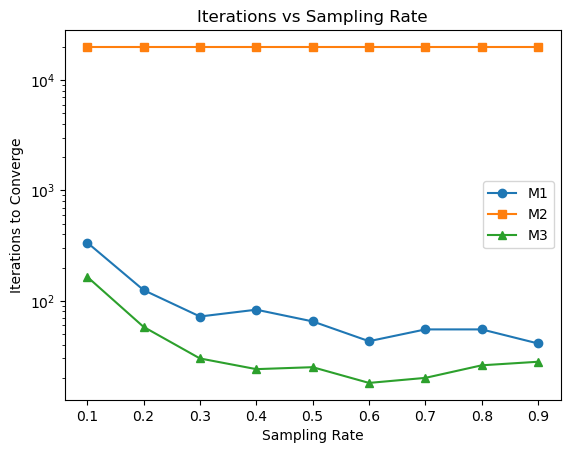

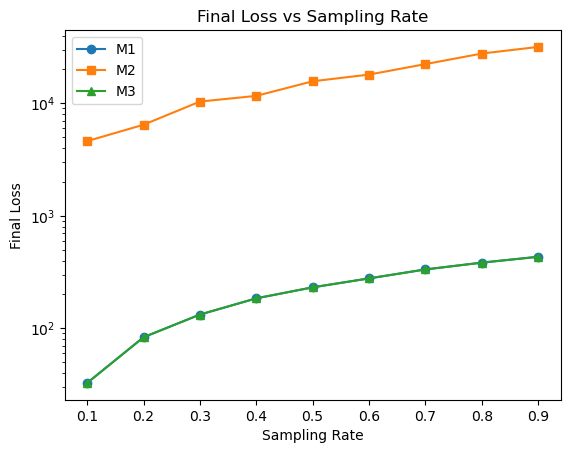

In [11]:
m, n, r = 200, 500, 5
out = compare_manifolds(m, n, r)
plot_comparisons(*out)

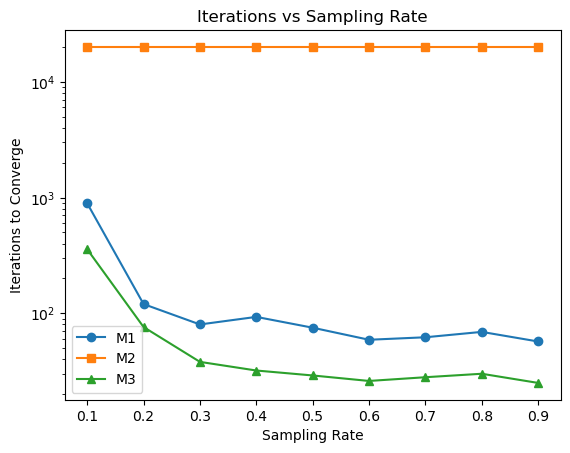

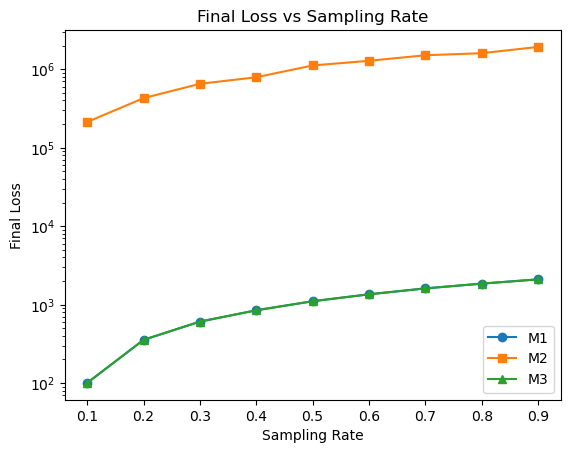

In [12]:
m, n, r = 500, 1000, 20
out = compare_manifolds(m, n, r)
plot_comparisons(*out)